In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
import odl
import odl.contrib.tensorflow
from odl.trafos.non_uniform_fourier import NonUniformFourierTransform
import scipy.io
from skimage.measure import compare_ssim as ssim
import tensorflow as tf

In [2]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# redefining adler's prelu
# https://github.com/adler-j/adler/blob/master/adler/tensorflow/activation.py
def prelu(_x, init=0.0, name='prelu', trainable=True):
    with tf.variable_scope(name):
        alphas = tf.get_variable('alphas',
                                 shape=[int(_x.get_shape()[-1])],
                                 initializer=tf.constant_initializer(init),
                                 dtype=tf.float64,
                                 trainable=True)
        pos = tf.nn.relu(_x)
        neg = -alphas * tf.nn.relu(-_x)

        return pos + neg
    
def apply_conv(x, filters=32):
    return tf.layers.conv2d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

def prelu_conv_complex(x, filters=32, name='prelu'):
    with tf.variable_scope(name):
        x_real = tf.math.real(x)
        x_imag = tf.math.imag(x)   
        with tf.variable_scope('real_conv', reuse=False):
            res_real = prelu(apply_conv(x_real, filters=filters))
        with tf.variable_scope('imag_conv', reuse=False):
            res_imag = prelu(apply_conv(x_imag, filters=filters))
    return tf.complex(res_real, res_imag)

In [4]:
# define the nfft samples
sparkling_traj_file_path = '2019-Mar-01_N512_nc34_ns3073_OS1_decim64_decay2_tau0.75_nrevol1/samples_SPARKLING_N512_nc34x3073_OS1.mat'
kspace_loc = scipy.io.loadmat(sparkling_traj_file_path)['samples'] / (2 * 1280)
kspace_loc[np.where(kspace_loc == 0.5)] = -0.5
kspace_loc = kspace_loc.astype(np.float64)

In [5]:
kspace_loc.shape[0] / 512**2

0.39856719970703125

In [6]:
# define odl stuff
# Create ODL data structures
size = 512
space = odl.uniform_discr([-size//2, -size//2], [size//2, size//2], [size, size], dtype='complex128')

operator = NonUniformFourierTransform(space=space, samples=kspace_loc, skip_normalization=True)

# Ensure operator has fixed operator norm for scale invariance
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator, 'NFFT')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint, 'NFFTAdjoint')

In [7]:
# Network parameters
n_iter = 10
n_primal = 3
n_dual = 1
# tf params
checkpoint_path = 'fft_chkpt/chkpt_{run_id}'

In [8]:
def process_image(image):
    image -= image.min()
    image /= image.max()
    kspace_data = operator(image)
    return kspace_data[np.newaxis, ..., np.newaxis]

batch_size = 1
baboon = np.load('baboon.npy').astype(np.complex64)
kspace_baboon = process_image(baboon)

In [9]:
run_id = '1558535056'

sess = tf.InteractiveSession()
n_filters = 32
# define the model
with tf.name_scope('placeholders'):
    y_rt = tf.placeholder(tf.complex128, shape=[batch_size, operator.range.shape[0], 1], name="y_rt")

with tf.name_scope('MRI'):
    with tf.name_scope('initial_values'):
        primal = tf.concat([tf.zeros([batch_size, size, size, 1], tf.complex128)] * n_primal, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            evalop = odl_op_layer(primal[..., 1:2])
            dual = evalop - y_rt

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            update = prelu_conv_complex(update, name='prelu_1', filters=n_filters)
            update = prelu_conv_complex(update, name='prelu_2', filters=n_filters)
            update = tf.complex(apply_conv(tf.math.real(update), filters=n_primal), apply_conv(tf.math.imag(update), filters=n_primal))
            primal = primal + update

    x_result = primal[..., 0:1]
    

# Initialize all TF variables
sess.run(tf.global_variables_initializer())

# Add op to save and restore
saver = tf.train.Saver()

saver.restore(sess, checkpoint_path.format(run_id=run_id))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from fft_chkpt/chkpt_1558535056


In [10]:
image_recon = sess.run([x_result], feed_dict={y_rt: kspace_baboon})

In [11]:
loss = np.mean((np.abs(np.squeeze(image_recon)) - np.abs(baboon))**2)
psnr = -10 * np.log10(loss)
print('MSE', loss)
print('NMSE', loss / np.mean(np.abs(baboon)))
print('NRMSE', np.sqrt(loss) / np.mean(np.abs(baboon)))
print('PSNR', psnr)
s = ssim(np.abs(np.squeeze(image_recon)), np.abs(baboon))
print('SSIM', s)

MSE 0.00023503600852
NMSE 0.00415506825045
NRMSE 0.271026002966
PSNR 36.2886559686
SSIM 0.928850740004


/volatile/home/Zaccharie/workspace/learned_primal_dual/venv/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


<IPython.core.display.Javascript object>


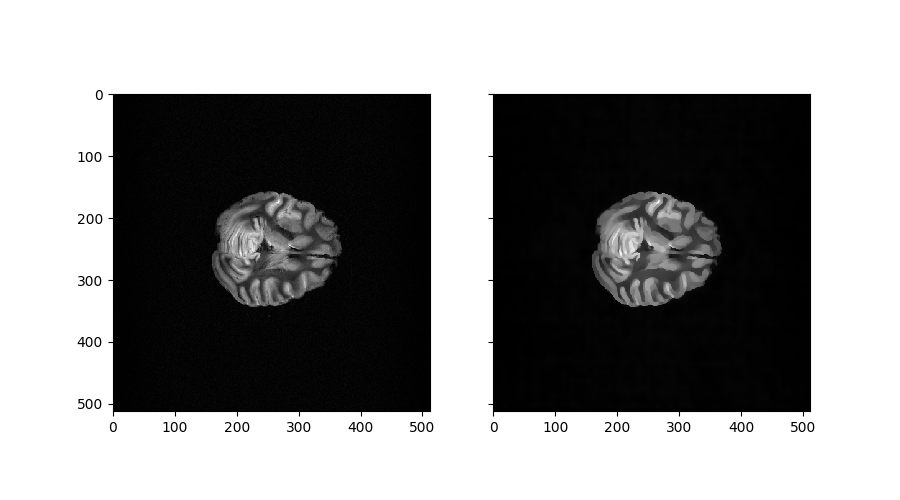

In [14]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(np.abs(baboon))
axs[1].imshow(np.abs(np.squeeze(image_recon)))